### Get Latest log in folder 

In [136]:
from plottinglib import *

In [4]:
def get_newest_file_in_folder(folder_path:str='../logs', extension="*."):
    import os
    import glob
    if extension == "*":
        search_pattern = os.path.join(folder_path, "*")
    else:
        search_pattern = os.path.join(folder_path, f"*.{extension}")
    files = glob.glob(search_pattern)
    if not files:
        return None
    
    newest_file = max(files, key=os.path.getmtime)
    return newest_file

folder_path = "../logs"  # Replace with the path to your folder
extension = "json"  # Replace with the desired file extension (e.g., 'txt', 'jpg', 'py')
newest_file = get_newest_file_in_folder(folder_path, extension)
print(newest_file)

../logs\test_02072025_100739.json


### Clean/Filter Trajectories

Total time: 99.588 s (1.660 min)
Average time per episode: 12.449 s


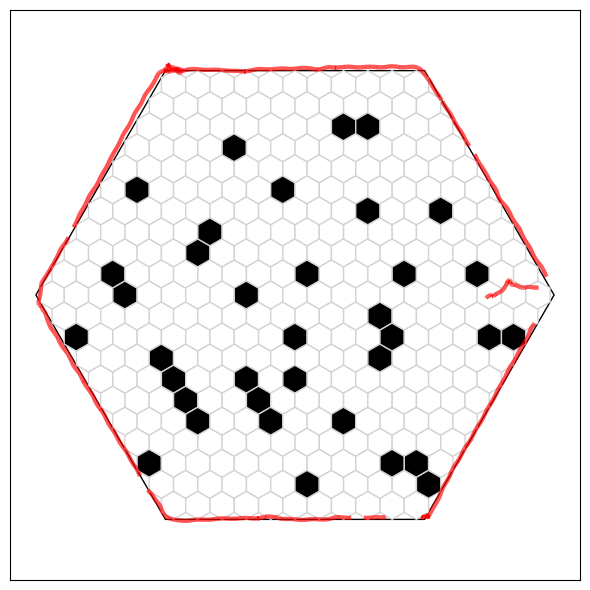

In [16]:
import cellworld as cw
import matplotlib.pyplot as plt
import numpy as np
# Load world and experiment data

import math

def scale_legacy_y(y):
    return y * 0.5 * math.sqrt(3) + 0.5 - math.sqrt(3) / 4

def scale_legacy_x(x):
    return y * 0.5 * math.sqrt(3) + 0.5 - math.sqrt(3) / 4

file = "..\\logs\\walk_02072025_092311.json"

w = cw.World.get_from_parameters_names('hexagonal',"canonical",'21_05')
d = cw.Display(w, fig_size=(6,6), padding=0.1, cell_edge_color="lightgrey", background_color="white", habitat_edge_color="black")

n     = 0
t_sum = 0

exp = cw.Experiment.load_from_file(file)

# Define hexagonal world bounds

for idx in range(len(exp.episodes)):
    episode = exp.episodes[idx]
    preyt = episode.trajectories.get_agent_trajectory('prey')
    predt = episode.trajectories.get_agent_trajectory('predator')
        
    # if len(episode.captures)>1:
    #     # print(f'Episode {idx} has 0 captures ({episode.captures}). Skipping...')
    #     continue

    for step in preyt: 
        step.location.y = scale_legacy_y(step.location.y)

    d.add_trajectories(preyt, colors = {'prey': 'red'}, alphas = {'prey': .9}, zorder = 7)
    # d.add_trajectories(predt, colors = {'predator': 'red'}, alphas = {'predator': .7}, zorder = 7)
    # summary info 
    n+=1 
    t_sum += len(preyt) * np.diff(preyt.get('time_stamp')).mean()

print(f'Total time: {t_sum:.3f} s ({t_sum/60:.3f} min)')
print(f'Average time per episode: {t_sum / n :.3f} s')

In [ ]:
import cellworld as cw
import matplotlib.pyplot as plt

# Load world and experiment data
file = "..\\logs\\test_02072025_100739.json"
exp = cw.Experiment.load_from_file(file)

# Define hexagonal world bounds

class Bounds:
    def __init__(self):
        self.low = -0.05
        self.high = 1.05
        pass

def is_within_bounds(trajectory, bounds):
    """Check if a trajectory stays within the hexagonal bounds."""
    for step in trajectory:
        if (-0.01 <= step.location.x <= 1) and (-0.01 <= step.location.y <= 0.99):
            return True
        
    print('out')
    return False

bounds = Bounds()
w = cw.World.get_from_parameters_names('hexagonal',"canonical",'21_05')
d = cw.Display(w, fig_size=(6,6), padding=0.1, cell_edge_color="lightgrey", background_color="white", habitat_edge_color="black")

print(f'Number of trials (raw): {len(exp.episodes)}')
# print(f'Number of trials (filtered): {len(exp.episodes)}')
data = dict()
data[file] = [6,8,18,19,30,31,32,33,34]

for i in range(len(exp.episodes)):
    if i not in data[file]: 
        episode = exp.episodes[i]
        ht = episode.trajectories.get_agent_trajectory('prey')
        x_vals = [step.location.x for step in ht]
        y_vals = [step.location.y for step in ht]
        d.add_trajectories(ht, colors = {'prey': 'green'}, alphas = {'prey': 0.7})


idx in range! idx= 0; len: 1


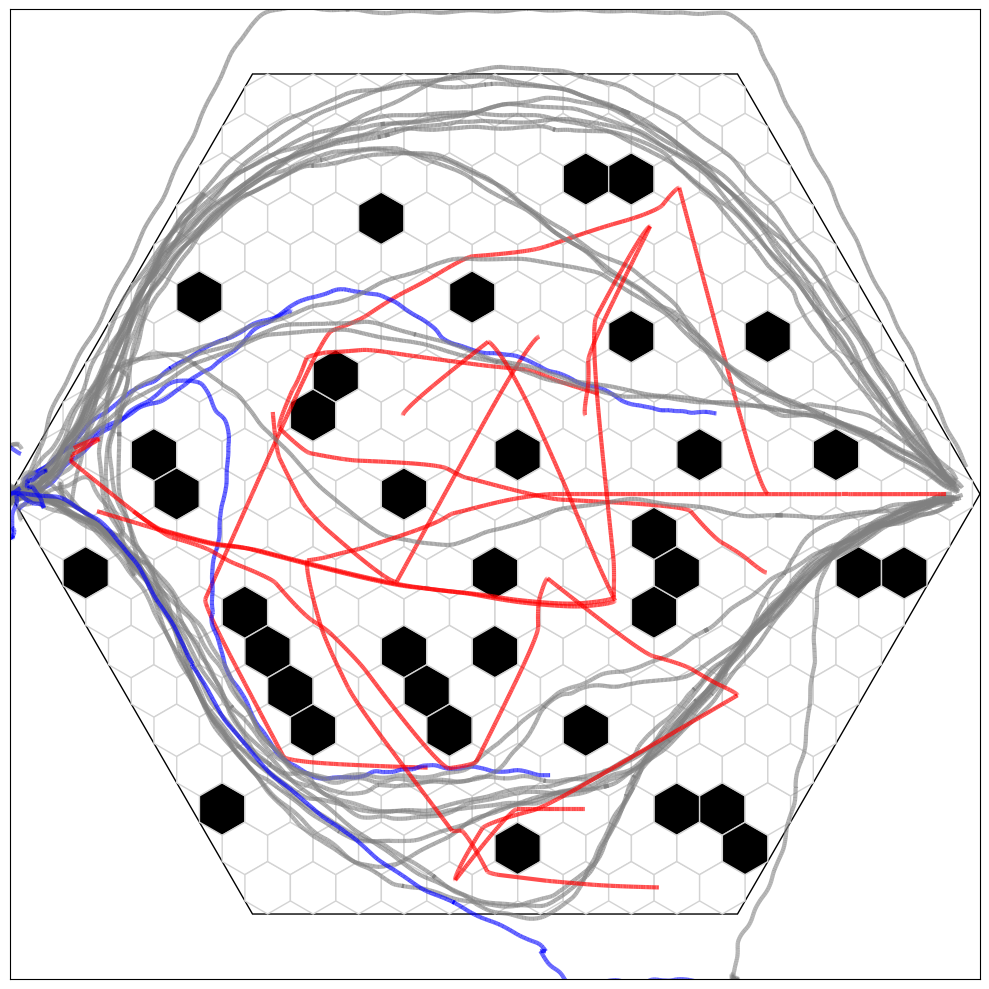

### Plotting

In [ ]:
## show summary info of trajectories 
# show time steps 

def detect_outliers(array):
    import numpy as np 
    mean = np.mean(array)
    std = np.std(array)
    lower_bound = mean - std
    upper_bound = mean + std
    outliers = array[(array < lower_bound) | (array > upper_bound)]
    
    if len(outliers) > 0:
        return f"Outliers detected: {outliers}"
    else:
        return "No outliers detected"
    
def show_info(filepath:str=None):
    import numpy as np
    if not filepath: print("need a filepath"); return

    e = Experiment.load_from_file(filepath)
    if e is None: 
        print("No experiment found: e is NONE")
        return 
    
    w = World.get_from_parameters_names('hexagonal',"canonical",e.occlusions)
    subject_str = 'prey'
    scalar = 1.0
    mv = 1.0
    print(f'Episode count: {len(e.episodes)}')
    grads = []
    for i, episode in enumerate(e.episodes[:]):
        t = episode.trajectories
        tprey = t.get_agent_trajectory('prey')
        tpred = t.get_agent_trajectory('predator')
        
        frame_list = tprey.get('frame')
        nv = [f/(max(frame_list)) for f in frame_list]
        grad = np.gradient(nv)
        grads.append(grad)

    return grads
    
g = show_info(file)

Episode count: 35


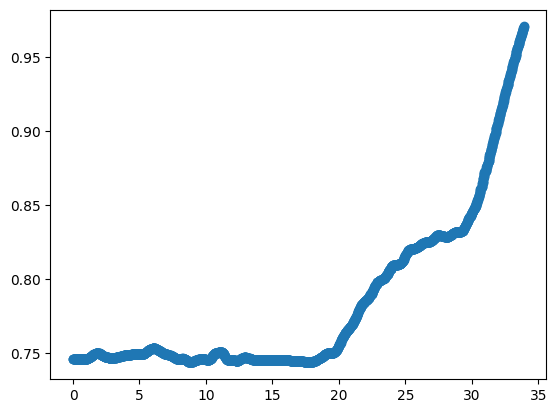

In [127]:
# file = '/mnt/c/Users/MacIver/Research/BotEvade/CellworldServer/main/cpp/robot_controller/logs/labtest_08202024_164619.json'
e = cw.Experiment.load_from_file(file)
w = cw.World.get_from_parameters_names('hexagonal',"canonical",e.occlusions)
subject_str = 'prey'
scalar = 1.0
mv = 1.0
print(f'Episode count: {len(e.episodes)}')
import numpy as np 
gp = []
gpp = []
for i, episode in enumerate(e.episodes[:]):
    t = episode.trajectories
    tprey = t.get_agent_trajectory('prey')
    frame_list = tprey.get('frame')
    gpp.append(tprey.get_locations())
    
xt = tprey.get('location').get('x')
tjson = tprey.get('time_stamp')
t = np.array(list(tjson)) - tjson[0]
plt.plot(t,xt,'--o')
# gpp = np.gradient(np.gradient(xt))
# print(gpp)
# print(np.where(np.nonzero(gpp)))
# xt = tprey.get_locations().get('prey').get('y')